# GLiNER Multi-Model Evaluation: Zero-Shot on Serbian Legal Documents

This notebook evaluates multiple GLiNER (Generalist and Lightweight Named Entity Recognition) models on 225 Serbian legal documents using English entity type descriptions for zero-shot NER.

## 🤖 **Models Tested:**
- urchade/gliner_multiv2.1
- knowledgator/gliner-x-large
- urchade/gliner_large-v2
- modern-gliner-bi-large-v1.0

## 🎯 **Evaluation Flow:**
1. **Setup**: Define everything needed for GLiNER
2. **Multi-Model Zero-Shot Evaluation**: Test all models without examples
3. **Results Analysis**: Compare performance across models

In [21]:
# Install required packages
!pip install gliner seqeval scikit-learn matplotlib seaborn pandas tqdm stanza langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 49.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=f228c0fb359be9f780c8ca62ffe29626d214cf194dfc319534728486012066f6
  Stored in directory: /root/.cache/pip/wheels/c1/67/88/e844b5b022812e15a52e4eaa38a1e709e99f06f6639d7e3ba7
Successfully built langdetect


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1. Setup: Define Everything Needed for GLiNER

In [23]:
# Import required libraries
import json
import os
from pathlib import Path
from typing import List, Dict, Optional
from collections import Counter
import time

# Data processing
import pandas as pd
import numpy as np
from tqdm import tqdm

# GLiNER
from gliner import GLiNER

# Evaluation metrics
from sklearn.metrics import classification_report
from seqeval.metrics import accuracy_score, precision_score, recall_score, f1_score
from seqeval.scheme import IOB2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
np.random.seed(42)

# Check GPU availability
import torch
if torch.cuda.is_available():
    print(f"🚀 GPU available: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("⚠️ GPU not available - will use CPU (slower)")

print("✅ All dependencies loaded successfully!")

🚀 GPU available: Tesla T4
💾 GPU memory: 15.8 GB
✅ All dependencies loaded successfully!


In [24]:
# Configuration
LABELSTUDIO_JSON_PATH = "/content/drive/MyDrive/NER_Master/annotations.json"  # Update path as needed
JUDGMENTS_DIR = "/content/drive/MyDrive/NER_Master/judgments"  # Path to judgment text files
CONFIDENCE_THRESHOLD = 0.3  # GLiNER confidence threshold

# GLiNER Models to Test
GLINER_MODELS = [
    "urchade/gliner_multiv2.1",
    "knowledgator/gliner-x-large",
    "urchade/gliner_large-v2",
    "knowledgator/modern-gliner-bi-large-v1.0"
]

# English Legal Entity Types for GLiNER Zero-Shot
LEGAL_ENTITY_TYPES = [
    "court or tribunal",  # COURT
    "judgment date or decision date",  # DECISION_DATE
    "case number or case identifier",  # CASE_NUMBER
    "criminal act or offense",  # CRIMINAL_ACT
    "prosecutor or public prosecutor",  # PROSECUTOR
    "defendant or accused person",  # DEFENDANT
    "judge or judicial officer",  # JUDGE
    "court registrar or clerk",  # REGISTRAR
    "court verdict or judgment",  # VERDICT
    "type of penalty or sanction",  # SANCTION_TYPE
    "amount or duration of penalty",  # SANCTION_VALUE
    "material legal provision or article",  # PROVISION_MATERIAL
    "procedural legal provision or article",  # PROVISION_PROCEDURAL
    "court procedure costs or fees",  # PROCEDURE_COSTS
]

# Mapping from English GLiNER labels to ground truth labels
GLINER_TO_GT_MAPPING = {
    "court or tribunal": "COURT",
    "judgment date or decision date": "DECISION_DATE",
    "case number or case identifier": "CASE_NUMBER",
    "criminal act or offense": "CRIMINAL_ACT",
    "prosecutor or public prosecutor": "PROSECUTOR",
    "defendant or accused person": "DEFENDANT",
    "judge or judicial officer": "JUDGE",
    "court registrar or clerk": "REGISTRAR",
    "court verdict or judgment": "VERDICT",
    "type of penalty or sanction": "SANCTION_TYPE",
    "amount or duration of penalty": "SANCTION_VALUE",
    "material legal provision or article": "PROVISION_MATERIAL",
    "procedural legal provision or article": "PROVISION_PROCEDURAL",
    "court procedure costs or fees": "PROCEDURE_COSTS",
}

print(f"🎯 Entity types: {len(LEGAL_ENTITY_TYPES)}")
print(f"🤖 Models to test: {len(GLINER_MODELS)}")
print(f"⚡ Confidence threshold: {CONFIDENCE_THRESHOLD}")
print(f"\n📋 Models:")
for i, model in enumerate(GLINER_MODELS, 1):
    print(f"  {i}. {model}")

🎯 Entity types: 14
🤖 Models to test: 4
⚡ Confidence threshold: 0.3

📋 Models:
  1. urchade/gliner_multiv2.1
  2. knowledgator/gliner-x-large
  3. urchade/gliner_large-v2
  4. knowledgator/modern-gliner-bi-large-v1.0


In [25]:
def load_ground_truth_data():
    """Load ground truth data from LabelStudio annotations"""
    print("📂 Loading LabelStudio annotations...")

    # Create reverse mapping from BIO labels to English GLiNER labels
    label_to_english = {label: english_label for english_label, label in GLINER_TO_GT_MAPPING.items()}
    print(f"🔄 Created mapping for {len(label_to_english)} entity types")

    try:
        with open(LABELSTUDIO_JSON_PATH, 'r', encoding='utf-8') as f:
            labelstudio_data = json.load(f)
        print(f"✅ Loaded {len(labelstudio_data)} annotated documents")
    except FileNotFoundError:
        print(f"❌ Error: {LABELSTUDIO_JSON_PATH} not found!")
        return []

    ground_truth_examples = []
    entity_types = set()
    bio_labels_found = set()

    for item in tqdm(labelstudio_data, desc="Loading ground truth"):
        file_path = item.get("file_upload", "")

        # Load text file
        if "/" in file_path:
            filename = file_path.split("/")[-1]
        else:
            filename = file_path

        full_path = Path(JUDGMENTS_DIR) / filename

        if not full_path.exists():
            continue

        try:
            with open(full_path, 'r', encoding='utf-8') as f:
                text_content = f.read().strip()
        except Exception as e:
            print(f"❌ Error reading {full_path}: {e}")
            continue

        # Extract entities
        annotations = item.get("annotations", [])
        for annotation in annotations:
            entities = []
            result = annotation.get("result", [])

            for res in result:
                if res.get("type") == "labels":
                    value = res["value"]
                    start = value["start"]
                    end = value["end"]
                    labels = value["labels"]

                    for bio_label in labels:
                        bio_labels_found.add(bio_label)

                        # Convert BIO label to English GLiNER label
                        english_label = label_to_english.get(bio_label)
                        if english_label:
                            entity_types.add(english_label)
                            entities.append({
                                'text': text_content[start:end],
                                'label': english_label,  # Use English GLiNER label
                                'start': start,
                                'end': end,
                                'bio_label': bio_label  # Keep original for reference
                            })
                        else:
                            print(f"⚠️ Warning: Unknown BIO label '{bio_label}' - skipping")

            if entities:
                ground_truth_examples.append({
                    'text': text_content,
                    'entities': entities,
                    'file_path': file_path
                })

    print(f"✅ Loaded {len(ground_truth_examples)} examples with ground truth entities")
    print(f"🏷️ Found English GLiNER entity types: {sorted(entity_types)}")
    print(f"🔤 Found BIO labels: {sorted(bio_labels_found)}")

    # Show entity distribution
    entity_counts = Counter()
    for example in ground_truth_examples:
        for entity in example['entities']:
            entity_counts[entity['label']] += 1

    print(f"\n📊 Ground Truth Statistics:")
    print(f"  📄 Total examples: {len(ground_truth_examples)}")
    print(f"  🏷️ Entity types: {len(entity_types)}")
    print(f"\n📈 Entity Distribution:")
    for entity_type, count in entity_counts.most_common():
        print(f"  {entity_type}: {count}")

    return ground_truth_examples

# Load ground truth data
ground_truth_examples = load_ground_truth_data()

📂 Loading LabelStudio annotations...
🔄 Created mapping for 14 entity types
✅ Loaded 225 annotated documents



Loading ground truth: 100%|██████████| 225/225 [00:00<00:00, 334.06it/s]

✅ Loaded 225 examples with ground truth entities
🏷️ Found English GLiNER entity types: ['amount or duration of penalty', 'case number or case identifier', 'court or tribunal', 'court procedure costs or fees', 'court registrar or clerk', 'court verdict or judgment', 'criminal act or offense', 'defendant or accused person', 'judge or judicial officer', 'judgment date or decision date', 'material legal provision or article', 'procedural legal provision or article', 'prosecutor or public prosecutor', 'type of penalty or sanction']
🔤 Found BIO labels: ['CASE_NUMBER', 'COURT', 'CRIMINAL_ACT', 'DECISION_DATE', 'DEFENDANT', 'JUDGE', 'PROCEDURE_COSTS', 'PROSECUTOR', 'PROVISION_MATERIAL', 'PROVISION_PROCEDURAL', 'REGISTRAR', 'SANCTION_TYPE', 'SANCTION_VALUE', 'VERDICT']

📊 Ground Truth Statistics:
  📄 Total examples: 225
  🏷️ Entity types: 14

📈 Entity Distribution:
  defendant or accused person: 1240
  material legal provision or article: 1177
  criminal act or offense: 792
  procedural legal p

In [26]:
class GLiNEREvaluator:
    """GLiNER NER Evaluator for Serbian Legal Documents"""

    def __init__(self, confidence_threshold: float = 0.3):
        self.model = None
        self.model_name = None
        self.confidence_threshold = confidence_threshold
        print(f"🌟 GLiNER Evaluator initialized with confidence threshold: {confidence_threshold}")

    def load_model(self, model_name: str):
        """Load a specific GLiNER model"""
        print(f"\n🔄 Loading GLiNER model: {model_name}")

        # Clean up previous model if exists
        if self.model is not None:
            del self.model
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

        try:
            # Load GLiNER model
            self.model = GLiNER.from_pretrained(model_name)

            # Enable GPU if available
            if torch.cuda.is_available():
                self.model = self.model.cuda()
                print(f"🚀 GPU enabled: {torch.cuda.get_device_name(0)}")
            else:
                print("⚠️ GPU not available, using CPU")

            self.model_name = model_name
            print(f"✅ GLiNER model {model_name} loaded successfully")
            return True

        except Exception as e:
            print(f"❌ Error loading GLiNER model {model_name}: {e}")
            self.model = None
            self.model_name = None
            return False

    def predict_entities(self, text: str, entity_types: List[str]) -> List[Dict]:
        """Predict entities using GLiNER zero-shot approach"""
        if self.model is None:
            return []

        try:
            method =  "gliner_zero_shot"

            # Zero-shot prediction
            entities = self.model.predict_entities(
                text,
                labels=entity_types,
                threshold=self.confidence_threshold
            )

            # Convert to our format
            formatted_entities = []
            for entity in entities:
                formatted_entities.append({
                    "text": entity["text"],
                    "label": entity["label"],
                    "start": entity["start"],
                    "end": entity["end"],
                    "confidence": entity["score"],
                    "method": method,
                    "model": self.model_name
                })

            return sorted(formatted_entities, key=lambda x: x["start"])

        except Exception as e:
            print(f"❌ Error in GLiNER prediction: {e}")
            return []

# Initialize GLiNER evaluator (models will be loaded individually)
gliner_evaluator = GLiNEREvaluator(confidence_threshold=CONFIDENCE_THRESHOLD)

🌟 GLiNER Evaluator initialized with confidence threshold: 0.3


## 2. Zero-Shot Evaluation

In [27]:
def evaluate_gliner(examples, entity_types, evaluator, method_name="GLiNER"):
    """Evaluate GLiNER on the given examples"""
    print(f"\n🧪 Starting {method_name} Evaluation")
    print("=" * 60)

    if evaluator.model is None:
        return {"error": "GLiNER model not loaded"}

    detailed_results = []
    prediction_counts = Counter()
    confidence_scores = []

    print(f"📊 Evaluating on {len(examples)} examples...")
    start_time = time.time()

    for i, example in enumerate(tqdm(examples, desc=f"{method_name} Evaluation")):
        text = example["text"]
        true_entities = example["entities"]

        # Get GLiNER predictions
        pred_entities = evaluator.predict_entities(text, entity_types)

        # Count predictions by type
        for entity in pred_entities:
            prediction_counts[entity["label"]] += 1
            confidence_scores.append(entity["confidence"])

        # Store detailed results
        detailed_results.append({
            "example_id": i,
            "text": text[:200] + "..." if len(text) > 200 else text,
            "file_path": example["file_path"],
            "true_entities": true_entities,
            "pred_entities": pred_entities,
            "true_count": len(true_entities),
            "pred_count": len(pred_entities)
        })

    end_time = time.time()
    evaluation_time = end_time - start_time

    # Calculate statistics
    total_true = sum(len(r["true_entities"]) for r in detailed_results)
    total_pred = sum(len(r["pred_entities"]) for r in detailed_results)
    avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0

    print(f"\n📊 {method_name} Prediction Statistics:")
    for label, count in prediction_counts.most_common():
        print(f"  {label}: {count}")

    results = {
        "method": method_name,
        "model_name": evaluator.model_name,
        "confidence_threshold": evaluator.confidence_threshold,
        "detailed_results": detailed_results,
        "total_true_entities": total_true,
        "total_pred_entities": total_pred,
        "prediction_counts": dict(prediction_counts),
        "examples_evaluated": len(examples),
        "avg_confidence": avg_confidence,
        "evaluation_time": evaluation_time,
        "entities_per_second": total_pred / evaluation_time if evaluation_time > 0 else 0
    }

    print(f"✅ {method_name} evaluation complete!")
    print(f"  📊 True entities: {total_true}")
    print(f"  🤖 Predicted entities: {total_pred}")
    print(f"  ⚡ Average confidence: {avg_confidence:.3f}")
    print(f"  ⏱️ Evaluation time: {evaluation_time:.2f}s")
    print(f"  🚀 Entities/second: {results['entities_per_second']:.2f}")

    return results

# Run zero-shot evaluation for all models
all_model_results = {}
failed_models = []

print(f"\n🚀 Starting evaluation of {len(GLINER_MODELS)} GLiNER models...")
print("=" * 80)

for i, model_name in enumerate(GLINER_MODELS, 1):
    print(f"\n📊 Model {i}/{len(GLINER_MODELS)}: {model_name}")
    print("-" * 60)

    # Load the model
    if gliner_evaluator.load_model(model_name):
        # Run evaluation
        model_results = evaluate_gliner(
            ground_truth_examples,
            LEGAL_ENTITY_TYPES,
            gliner_evaluator,
            method_name=f"Zero-Shot {model_name}"
        )

        if "error" not in model_results:
            all_model_results[model_name] = model_results
            print(f"✅ {model_name} evaluation completed successfully")
        else:
            failed_models.append(model_name)
            print(f"❌ {model_name} evaluation failed: {model_results['error']}")
    else:
        failed_models.append(model_name)
        print(f"❌ Failed to load {model_name}")

print(f"\n🎉 Evaluation complete!")
print(f"✅ Successfully evaluated: {len(all_model_results)} models")
print(f"❌ Failed models: {len(failed_models)}")
if failed_models:
    print(f"   Failed: {', '.join(failed_models)}")


🚀 Starting evaluation of 4 GLiNER models...

📊 Model 1/4: urchade/gliner_multiv2.1
------------------------------------------------------------

🔄 Loading GLiNER model: urchade/gliner_multiv2.1


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

🚀 GPU enabled: Tesla T4
✅ GLiNER model urchade/gliner_multiv2.1 loaded successfully

🧪 Starting Zero-Shot urchade/gliner_multiv2.1 Evaluation
📊 Evaluating on 225 examples...



Zero-Shot urchade/gliner_multiv2.1 Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

Zero-Shot urchade/gliner_multiv2.1 Evaluation: 100%|██████████| 225/225 [00:32<00:00,  6.94it/s]



📊 Zero-Shot urchade/gliner_multiv2.1 Prediction Statistics:
  defendant or accused person: 938
  court or tribunal: 287
  criminal act or offense: 252
  court registrar or clerk: 242
  judge or judicial officer: 204
  amount or duration of penalty: 9
  court verdict or judgment: 6
  case number or case identifier: 5
  court procedure costs or fees: 1
  prosecutor or public prosecutor: 1
✅ Zero-Shot urchade/gliner_multiv2.1 evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 1945
  ⚡ Average confidence: 0.688
  ⏱️ Evaluation time: 32.40s
  🚀 Entities/second: 60.02
✅ urchade/gliner_multiv2.1 evaluation completed successfully

📊 Model 2/4: knowledgator/gliner-x-large
------------------------------------------------------------

🔄 Loading GLiNER model: knowledgator/gliner-x-large


Fetching 197 files:   0%|          | 0/197 [00:00<?, ?it/s]

🚀 GPU enabled: Tesla T4
✅ GLiNER model knowledgator/gliner-x-large loaded successfully

🧪 Starting Zero-Shot knowledgator/gliner-x-large Evaluation
📊 Evaluating on 225 examples...



Zero-Shot knowledgator/gliner-x-large Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]ERROR:stanza:Cannot load model from /root/stanza_resources/hr/tokenize/set.pt
/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 2167 has been truncated to 1024
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

Zero-Shot knowledgator/gliner-x-large Evaluation:   0%|          | 1/225 [00:03<11:52,  3.18s/it]
Zero-Shot knowledgator/gliner-x-large Evaluation:   1%|          | 2/225 [00:03<05:59,  1.61s/it]
Zero-Shot knowledgator/gliner-x-large Evaluation:   1%|▏         | 3/225 [00:04<03:54,  1.06s/it]
Zero-Shot knowledgator/gliner-x-large Evaluation:   2%|▏         | 4/225 [00:04<03:00,  1.23it/s]
Zero-Shot knowledgator/gliner-x-large Evaluation:   2%|▏         | 5


📊 Zero-Shot knowledgator/gliner-x-large Prediction Statistics:
  defendant or accused person: 5918
  court or tribunal: 2665
  material legal provision or article: 2141
  criminal act or offense: 1893
  prosecutor or public prosecutor: 1373
  judgment date or decision date: 1355
  amount or duration of penalty: 1040
  case number or case identifier: 804
  court verdict or judgment: 565
  type of penalty or sanction: 538
  procedural legal provision or article: 230
  court procedure costs or fees: 102
  judge or judicial officer: 54
  court registrar or clerk: 32
✅ Zero-Shot knowledgator/gliner-x-large evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 18710
  ⚡ Average confidence: 0.466
  ⏱️ Evaluation time: 230.20s
  🚀 Entities/second: 81.28
✅ knowledgator/gliner-x-large evaluation completed successfully

📊 Model 3/4: urchade/gliner_large-v2
------------------------------------------------------------

🔄 Loading GLiNER model: urchade/gliner_large-v2


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

🚀 GPU enabled: Tesla T4
✅ GLiNER model urchade/gliner_large-v2 loaded successfully

🧪 Starting Zero-Shot urchade/gliner_large-v2 Evaluation
📊 Evaluating on 225 examples...



Zero-Shot urchade/gliner_large-v2 Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.

Zero-Shot urchade/gliner_large-v2 Evaluation: 100%|██████████| 225/225 [01:16<00:00,  2.95it/s]



📊 Zero-Shot urchade/gliner_large-v2 Prediction Statistics:
  defendant or accused person: 786
  criminal act or offense: 308
  procedural legal provision or article: 261
  judge or judicial officer: 185
  material legal provision or article: 184
  court registrar or clerk: 109
  prosecutor or public prosecutor: 92
  court or tribunal: 57
  case number or case identifier: 40
  type of penalty or sanction: 39
  court verdict or judgment: 34
  amount or duration of penalty: 17
✅ Zero-Shot urchade/gliner_large-v2 evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 2112
  ⚡ Average confidence: 0.517
  ⏱️ Evaluation time: 76.18s
  🚀 Entities/second: 27.72
✅ urchade/gliner_large-v2 evaluation completed successfully

📊 Model 4/4: knowledgator/modern-gliner-bi-large-v1.0
------------------------------------------------------------

🔄 Loading GLiNER model: knowledgator/modern-gliner-bi-large-v1.0


Fetching 9 files:   0%|          | 0/9 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

🚀 GPU enabled: Tesla T4
✅ GLiNER model knowledgator/modern-gliner-bi-large-v1.0 loaded successfully

🧪 Starting Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation
📊 Evaluating on 225 examples...



Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation:   0%|          | 0/225 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/gliner/data_processing/processor.py:351: UserWarning: Sentence of length 2506 has been truncated to 2048
  warnings.warn(f"Sentence of length {len(tokens)} has been truncated to {max_len}")
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
W0925 16:11:30.202000 1360 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode

Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation:   0%|          | 1/225 [00:10<40:43, 10.91s/it]
Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation:   1%|          | 2/225 [00:11<17:37,  4.74s/it]
Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation:   1%|▏         | 3/225 [00:11<10:04,  2.72s/it]
Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Evaluation:   2%|▏         | 4


📊 Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 Prediction Statistics:
  judgment date or decision date: 7
  court registrar or clerk: 3
  amount or duration of penalty: 2
  judge or judicial officer: 1
✅ Zero-Shot knowledgator/modern-gliner-bi-large-v1.0 evaluation complete!
  📊 True entities: 7201
  🤖 Predicted entities: 13
  ⚡ Average confidence: 0.321
  ⏱️ Evaluation time: 272.30s
  🚀 Entities/second: 0.05
✅ knowledgator/modern-gliner-bi-large-v1.0 evaluation completed successfully

🎉 Evaluation complete!
✅ Successfully evaluated: 4 models
❌ Failed models: 0


## 3. Results Analysis

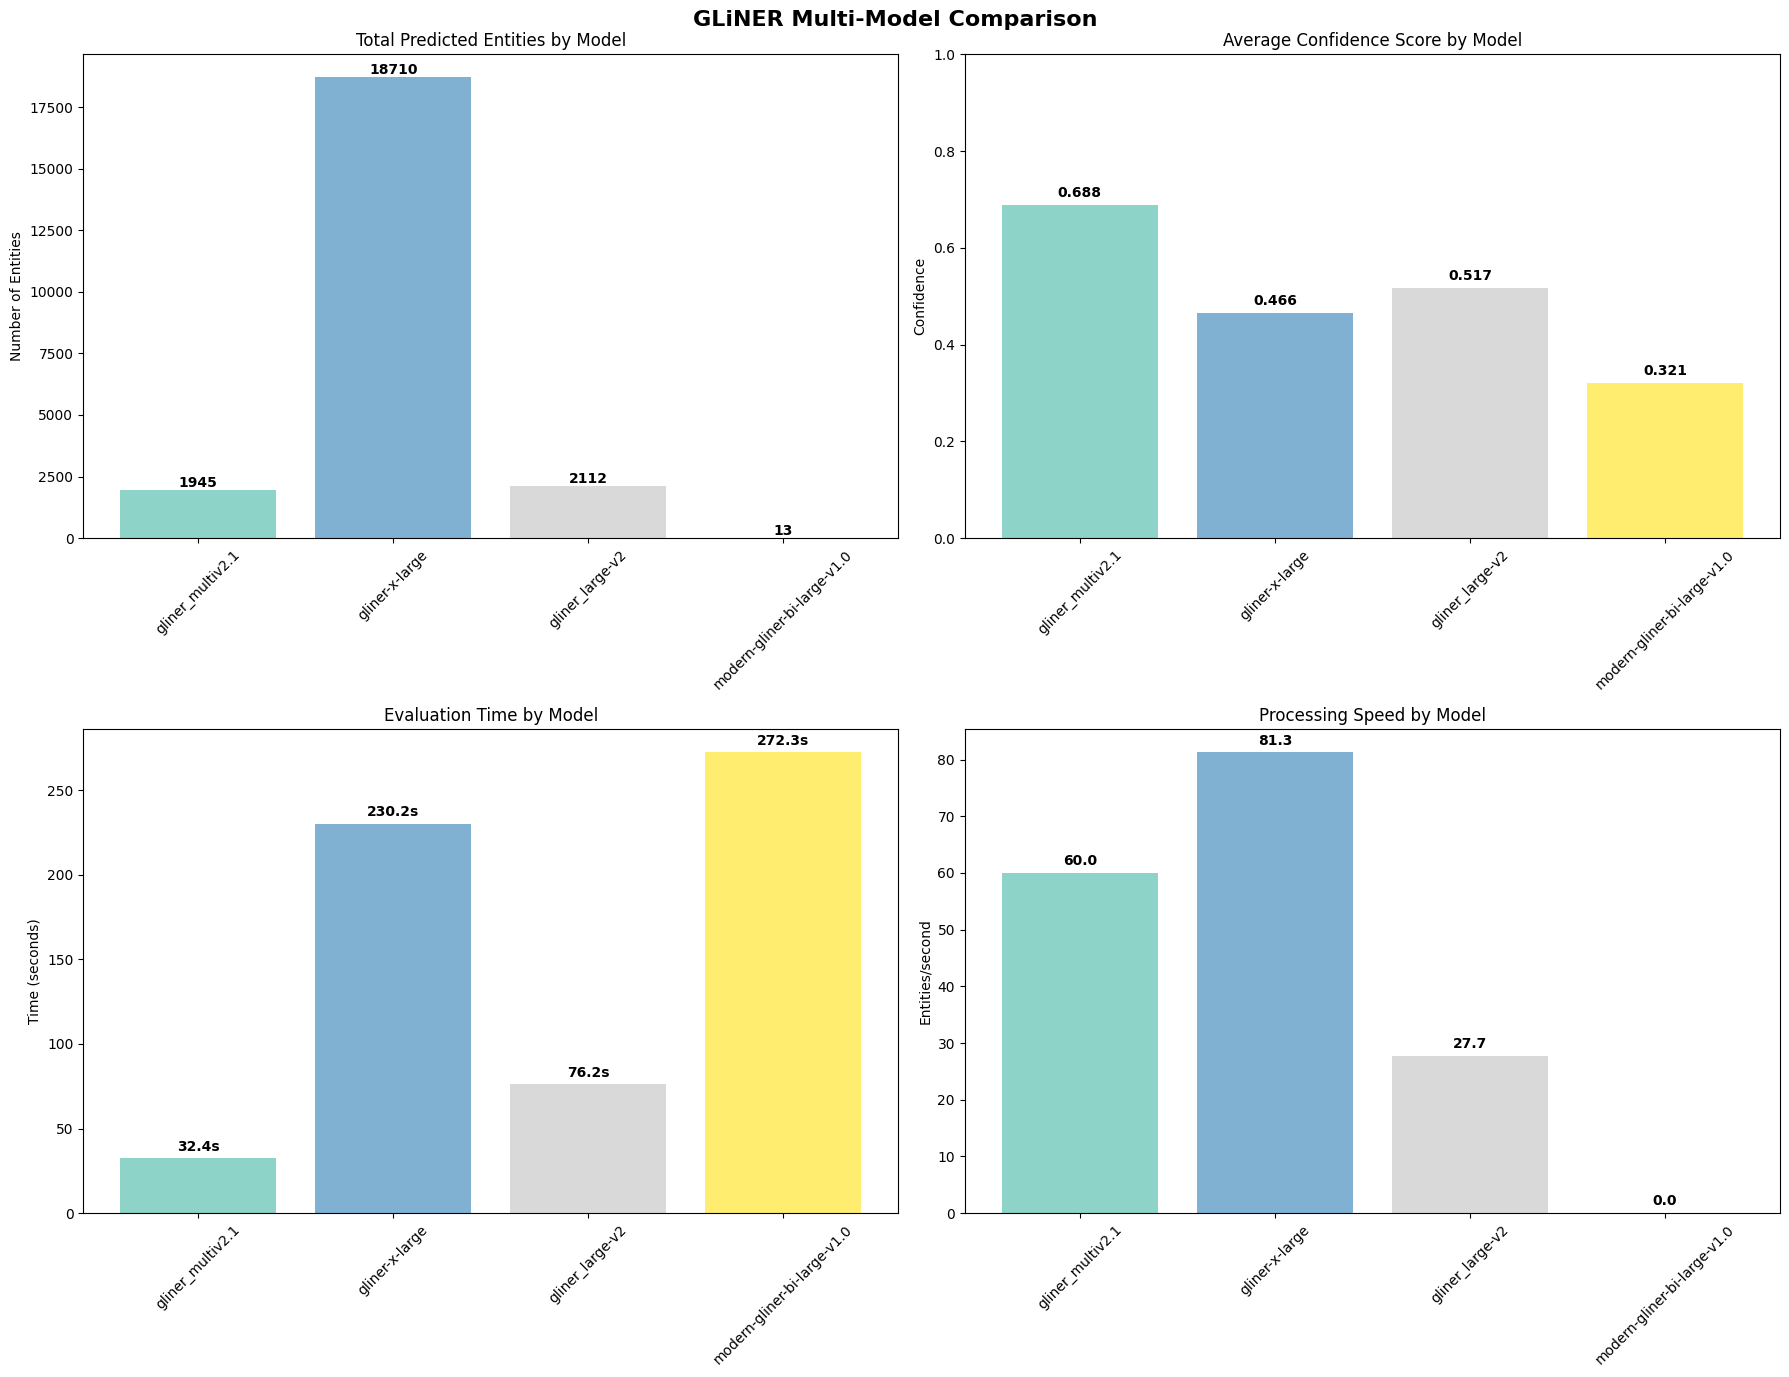

In [28]:
def create_results_visualization(all_model_results):
    """Create visualizations comparing results across multiple models"""
    if not all_model_results:
        print("⚠️ No results to visualize")
        return

    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    fig.suptitle('GLiNER Multi-Model Comparison', fontsize=16, fontweight='bold')

    # 1. Entity count comparison
    ax1 = axes[0, 0]
    model_names = [name.split('/')[-1] for name in all_model_results.keys()]  # Short names
    entity_counts = [results['total_pred_entities'] for results in all_model_results.values()]
    colors = plt.cm.Set3(np.linspace(0, 1, len(model_names)))

    bars1 = ax1.bar(model_names, entity_counts, color=colors)
    ax1.set_title('Total Predicted Entities by Model')
    ax1.set_ylabel('Number of Entities')
    ax1.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, count in zip(bars1, entity_counts):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
                str(count), ha='center', va='bottom', fontweight='bold')

    # 2. Confidence comparison
    ax2 = axes[0, 1]
    confidence_scores = [results['avg_confidence'] for results in all_model_results.values()]

    bars2 = ax2.bar(model_names, confidence_scores, color=colors)
    ax2.set_title('Average Confidence Score by Model')
    ax2.set_ylabel('Confidence')
    ax2.set_ylim(0, 1)
    ax2.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, conf in zip(bars2, confidence_scores):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{conf:.3f}', ha='center', va='bottom', fontweight='bold')

    # 3. Performance comparison (F1 scores would go here if calculated)
    ax3 = axes[1, 0]
    eval_times = [results['evaluation_time'] for results in all_model_results.values()]

    bars3 = ax3.bar(model_names, eval_times, color=colors)
    ax3.set_title('Evaluation Time by Model')
    ax3.set_ylabel('Time (seconds)')
    ax3.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, time_val in zip(bars3, eval_times):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(eval_times)*0.01,
                f'{time_val:.1f}s', ha='center', va='bottom', fontweight='bold')

    # 4. Entities per second comparison
    ax4 = axes[1, 1]
    entities_per_sec = [results['entities_per_second'] for results in all_model_results.values()]

    bars4 = ax4.bar(model_names, entities_per_sec, color=colors)
    ax4.set_title('Processing Speed by Model')
    ax4.set_ylabel('Entities/second')
    ax4.tick_params(axis='x', rotation=45)

    # Add value labels on bars
    for bar, speed in zip(bars4, entities_per_sec):
        ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(entities_per_sec)*0.01,
                f'{speed:.1f}', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Create visualizations
if 'all_model_results' in locals() and all_model_results:
    create_results_visualization(all_model_results)
else:
    print("⚠️ Results not available for visualization")

## 🎯 Proper Entity-Level Classification Report

In [29]:
def generate_entity_classification_report(results, method_name):
    """Generate proper entity-level classification report (no BIO tagging)"""
    print(f"\n📊 {method_name} - Entity-Level Classification Report:")
    print("=" * 80)

    if 'detailed_results' not in results:
        print("❌ No detailed results available")
        return

    # Entity-level evaluation
    entity_stats = {}
    total_true = 0
    total_pred = 0
    exact_matches = 0

    # Collect entity-level statistics
    for example_result in results['detailed_results']:
        true_entities = example_result['true_entities']
        pred_entities = example_result['pred_entities']

        total_true += len(true_entities)
        total_pred += len(pred_entities)

        # Count by entity type
        for entity in true_entities:
            label = entity['label']
            if label not in entity_stats:
                entity_stats[label] = {'true': 0, 'pred': 0, 'correct': 0}
            entity_stats[label]['true'] += 1

        for entity in pred_entities:
            label = entity['label']
            if label not in entity_stats:
                entity_stats[label] = {'true': 0, 'pred': 0, 'correct': 0}
            entity_stats[label]['pred'] += 1

        # Check for exact matches (same span and label)
        for true_entity in true_entities:
            for pred_entity in pred_entities:
                if (true_entity['start'] == pred_entity['start'] and
                    true_entity['end'] == pred_entity['end'] and
                    true_entity['label'] == pred_entity['label']):
                    entity_stats[true_entity['label']]['correct'] += 1
                    exact_matches += 1
                    break

    # Calculate metrics for each entity type
    print(f"{'Entity Type':<30} {'Precision':<10} {'Recall':<10} {'F1-Score':<10} {'Support':<10}")
    print("=" * 80)

    total_precision = 0
    total_recall = 0
    total_f1 = 0
    num_types = 0

    for label in sorted(entity_stats.keys()):
        stats = entity_stats[label]

        # Calculate precision, recall, F1
        precision = stats['correct'] / stats['pred'] if stats['pred'] > 0 else 0.0
        recall = stats['correct'] / stats['true'] if stats['true'] > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

        print(f"{label:<30} {precision:<10.2f} {recall:<10.2f} {f1:<10.2f} {stats['true']:<10d}")

        total_precision += precision
        total_recall += recall
        total_f1 += f1
        num_types += 1

    # Overall metrics
    print("=" * 80)
    overall_precision = exact_matches / total_pred if total_pred > 0 else 0.0
    overall_recall = exact_matches / total_true if total_true > 0 else 0.0
    overall_f1 = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) > 0 else 0.0

    print(f"{'Micro Avg':<30} {overall_precision:<10.2f} {overall_recall:<10.2f} {overall_f1:<10.2f} {total_true:<10d}")

    if num_types > 0:
        macro_precision = total_precision / num_types
        macro_recall = total_recall / num_types
        macro_f1 = total_f1 / num_types
        print(f"{'Macro Avg':<30} {macro_precision:<10.2f} {macro_recall:<10.2f} {macro_f1:<10.2f} {total_true:<10d}")

    print(f"\n📊 Summary:")
    print(f"  Total True Entities: {total_true}")
    print(f"  Total Predicted Entities: {total_pred}")
    print(f"  Exact Matches: {exact_matches}")
    accuracy = exact_matches/max(total_true, total_pred) if max(total_true, total_pred) > 0 else 0.0
    print(f"  Overall Accuracy: {accuracy:.2f}")

# Generate proper entity-level reports for all models
if 'all_model_results' in locals() and all_model_results:
    for model_name, results in all_model_results.items():
        generate_entity_classification_report(results, f"Zero-Shot {model_name}")
else:
    print("⚠️ No results available for classification reports")


📊 Zero-Shot urchade/gliner_multiv2.1 - Entity-Level Classification Report:
Entity Type                    Precision  Recall     F1-Score   Support   
amount or duration of penalty  0.00       0.00       0.00       241       
case number or case identifier 0.00       0.00       0.00       225       
court or tribunal              0.62       0.39       0.48       458       
court procedure costs or fees  0.00       0.00       0.00       231       
court registrar or clerk       0.76       0.40       0.53       460       
court verdict or judgment      0.00       0.00       0.00       238       
criminal act or offense        0.47       0.15       0.23       792       
defendant or accused person    0.37       0.28       0.32       1240      
judge or judicial officer      0.84       0.38       0.53       451       
judgment date or decision date 0.00       0.00       0.00       359       
material legal provision or article 0.00       0.00       0.00       1177      
procedural legal pr

In [30]:
# Save results for further analysis
if 'all_model_results' in locals() and all_model_results:
    results_summary = {
        "evaluation_date": time.strftime("%Y-%m-%d %H:%M:%S"),
        "models_tested": list(all_model_results.keys()),
        "models_failed": failed_models if 'failed_models' in locals() else [],
        "confidence_threshold": CONFIDENCE_THRESHOLD,
        "entity_types": LEGAL_ENTITY_TYPES,
        "ground_truth_examples_count": len(ground_truth_examples),
        "model_results": all_model_results,
    }

    # Save to JSON file
    output_file = "gliner_multi_model_evaluation_results.json"
    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results_summary, f, ensure_ascii=False, indent=2)

    print(f"\n💾 Results saved to {output_file}")
    print(f"\n🎉 GLiNER multi-model evaluation complete!")
    print(f"📊 Evaluated {len(ground_truth_examples)} documents")
    print(f"🤖 Tested {len(all_model_results)} models successfully")
    print(f"🏷️ Tested {len(LEGAL_ENTITY_TYPES)} entity types")

    # Print summary comparison
    print(f"\n📈 Model Performance Summary:")
    print(f"{'Model':<30} {'Entities':<10} {'Avg Conf':<10} {'Time (s)':<10} {'Speed':<12}")
    print("-" * 80)
    for model_name, results in all_model_results.items():
        short_name = model_name.split('/')[-1][:28]
        print(f"{short_name:<30} {results['total_pred_entities']:<10} {results['avg_confidence']:<10.3f} {results['evaluation_time']:<10.1f} {results['entities_per_second']:<12.1f}")
else:
    print("⚠️ No results to save")


💾 Results saved to gliner_multi_model_evaluation_results.json

🎉 GLiNER multi-model evaluation complete!
📊 Evaluated 225 documents
🤖 Tested 4 models successfully
🏷️ Tested 14 entity types

📈 Model Performance Summary:
Model                          Entities   Avg Conf   Time (s)   Speed       
--------------------------------------------------------------------------------
gliner_multiv2.1               1945       0.688      32.4       60.0        
gliner-x-large                 18710      0.466      230.2      81.3        
gliner_large-v2                2112       0.517      76.2       27.7        
modern-gliner-bi-large-v1.0    13         0.321      272.3      0.0         
